<h2>Results and cost calculations from realistic trials</h2>

In [1]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib
import types
import matplotlib.ticker as ticker

# Very important lines to run the setup notebooks!!!
%run do_plot_setup.ipynb
%run do_radical_count_setup.ipynb
get_cl_radical_budget = get_cl_radical_budget # Tautology to get rid of the yellow underlines
import cl2_utilities as cl2_utils

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

1 :  0.87  ±  0.3
2 :  1.71  ±  0.3
5 :  3.38  ±  0.3
10 :  7.61  ±  0.3
15 :  11.92  ±  0.36
20 :  17.21  ±  0.44
30 :  23.18  ±  0.36
60 :  51.18  ±  2.16
90 :  77.59  ±  2.18


In [2]:
# Load the data from the realistic AMR trial
current_data = types.SimpleNamespace()

# Select data from only the the experiments we want. The noise on any given trial is already quite low, so we just keep one trial.
exps = ["01-31-25 Realistic AMR","02-10-25 Realistic Barn","02-11-25 Realistic WWTP"]
current_data.bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
current_data.conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
current_data.conversion_data = current_data.conversion_data.sort_values('experiment_name')

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = [20,1000,1000]

# Extract the values and 95% CI from the CH4 conversion data
current_data.ch4_baselines = current_data.conversion_data["Selected: CH4 (ppm) baseline"]
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(current_data.conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)
current_data.ch4_conversion_percent = 100*current_data.ch4_conversions/current_data.ch4_baselines
current_data.ch4_conversion_percent_95_ci = 100*current_data.ch4_95_ci/current_data.ch4_baselines

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(current_data.conversion_data,current_data.bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
current_data.inlet_cl2 = current_data.cl2_baseline

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
(current_data.cl_budget[2],current_data.cl_budget_95_ci[2]) = get_cl_radical_budget_300() # The 300 ppm radical budget is evaluated separately, as mentioned in the text.s
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)

print("CH4 Conv % CI: ",100*current_data.ch4_95_ci/current_data.ch4_conversions)

print("Cl* Availability % CI: ",100*current_data.cl_budget_95_ci/current_data.cl_budget)
print("Cl* Availability CI: ",current_data.cl_budget_95_ci)

print("Cl* Usage % CI: ",current_data.cl_per_ch4)
print("Cl* Usage CI: ",current_data.cl_per_ch4_95_ci)

print()

# Compute the Cl2 feed per CH4 converted
current_data.cl2_fed_per_ch4_converted = current_data.cl2_baseline/current_data.ch4_conversions

# Save to variable and report success
realistic_trial_data = current_data
print("Loaded results for plotting into object 'realistic_trial_data'.")

CH4 Conv % CI:  [16.33182171  5.01763871  5.0044243 ]
Cl* Availability % CI:  [18.70633751  3.71892656  0.90190522]
Cl* Availability CI:  [0.60738924 3.11259717 4.52458028]
Cl* Usage % CI:  [5.04809985 3.33856186 5.77486624]
Cl* Usage CI:  [1.25357184 0.20851213 0.29365462]

Loaded results for plotting into object 'realistic_trial_data'.


In [3]:
# Load the data from the Cl2 sweep to use here

# Load data for the Cl2 sweep trial
current_data = types.SimpleNamespace()

# Select data from only the the experiments we want
exps = ["09-28-24 Vary Cl2 (20-90 ppm) at Fixed CH4","09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
conversion_data = conversion_data[(conversion_data['experiment_name']=="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4") | # Use exp. with 100 ppm Cl2 tank for Cl2 5-30 ppm and exp. with 1000 ppm Cl2 tank for 45-90 ppm.
                                  (conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']>40)] # Proxy for >=45 ppm is a Cl2 measurement of more than 85mV
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 reading minus zero (mV) baseline',ascending=True)
current_data.conversion_data = conversion_data
current_data.bypass_data = bypass_data

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = np.array([1000 if b>40 else 100 for b in conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']]) # We've confirmed that in this subset of trials, only Cl2 conc's 45 and over used the 1000 ppm Cl2 tank

# Extract the values and 95% CI from the CH4 conversion data
current_data.ch4_baselines = conversion_data["Selected: CH4 (ppm) baseline"]
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
current_data.inlet_cl2 = current_data.cl2_baseline

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)

# Compute the Cl2 feed per CH4 converted
current_data.cl2_fed_per_ch4_converted = current_data.cl2_baseline/current_data.ch4_conversions

# Save to variable and report success
cl2_sweep_data = current_data
print("Loaded results for plotting into object 'cl2_sweep_data'.")

Loaded results for plotting into object 'cl2_sweep_data'.


In [4]:
# Function that's shown in the cost contour plot. Note we assume a fixed (90%) reflector efficiency.
@np.vectorize
def get_cost_per_ton_ch4(cl_usage, cl2_fed_per_ch4_converted):
    #tons_cl2_per_ton_ch4 = (70.9060/16.04)*cl2_fed_per_ch4_converted
    #cl2_cost_per_ton_ch4 = tons_cl2_per_ton_ch4*cl2_experiment_constants.cost_per_ton_cl2
    #moles_photons_per_ton_ch4 = 62500*cl_usage*(1.0/cl2_experiment_constants.reflector_efficiency)*0.5 #Each UV photon produces 2 Cl*'s when it hits a Cl2
    #light_cost_per_ton_ch4 = moles_photons_per_ton_ch4*cl2_experiment_constants.LED_cost_per_mole_photons
    #return cl2_cost_per_ton_ch4+light_cost_per_ton_ch4
    return cl2_experiment_constants.cost_cl2_usage_coefficient*cl2_fed_per_ch4_converted + cl2_experiment_constants.cost_cl_radical_usage_coefficient*cl_usage

# Function to truncate colormap, from stackoverflow
import matplotlib.colors as mcolors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

Cost for BC- 30 : $ 3792.0 per tCH4
Cost for BC- 45 : $ 4747.0 per tCH4
Cost for BC- 60 : $ 5300.0 per tCH4
Cost for BC- 90 : $ 7487.0 per tCH4
Cost for  Atmos. : $ 7342.0 per tCH4
Cost for  Barn : $ 4899.0 per tCH4
Cost for  Sewer : $ 8477.0 per tCH4


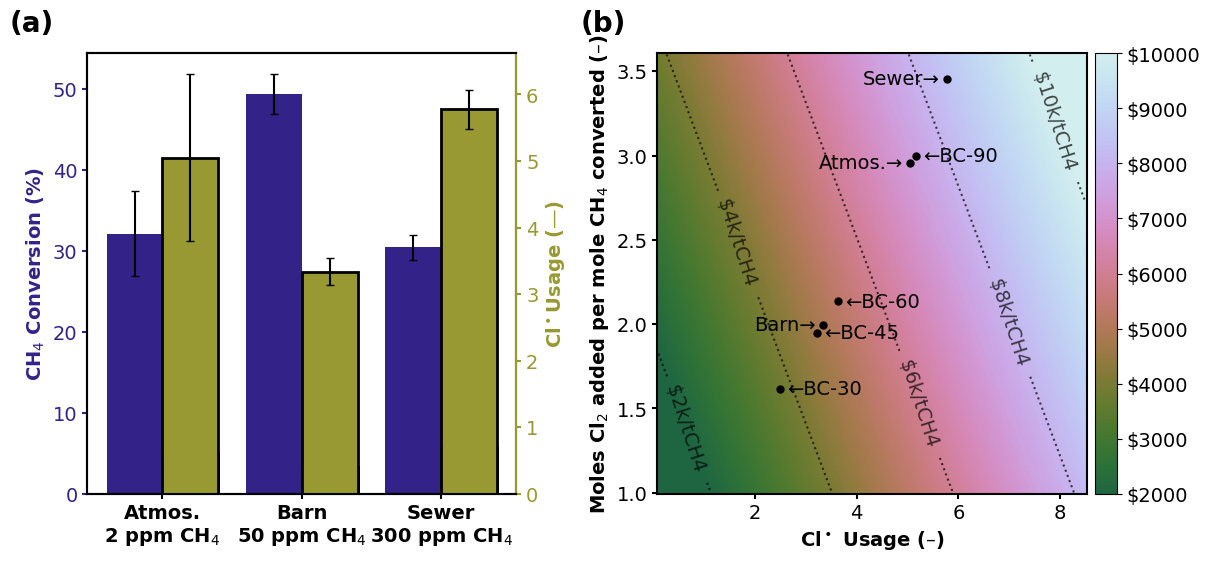

In [5]:
import matplotlib.ticker as mticker
(fig,((ax_a,ax_b)))=plt.subplots(1,2,figsize=(plot_default_properties['figure_width'],5.5))

# a
ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_a_right = ax_a.twinx()
ax_a_right.set_ylabel(line_default_properties['Cl* Efficiency']['text']+" (—)",fontweight=plot_default_properties['font_weight'])
ax_a_right.xaxis.set_tick_params(labelbottom=True)
right_ax_color = line_default_properties['Cl* Efficiency']['color']
ax_a_right.tick_params(axis='y', colors=right_ax_color)
ax_a_right.yaxis.label.set_color(right_ax_color)
ax_a_right.spines['right'].set_color(right_ax_color)
ax_a_right.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax_a.set_ylabel("CH$_4$ Conversion (%)",fontweight=plot_default_properties['font_weight'])
left_ax_color = line_default_properties['CH4']['color']
ax_a.tick_params(axis='y', colors=left_ax_color)
ax_a.yaxis.label.set_color(left_ax_color)
ax_a.spines['left'].set_color(left_ax_color)


# Bar plotting
x = np.arange(3)
width = 0.4  # the width of the bars
multiplier = 0
ax_a.bar(x - 0.5*width, realistic_trial_data.ch4_conversion_percent, width, label="CH$_4$ Conv.", color=line_default_properties['CH4']['color'])
ax_a.bar(x + 0.5*width, realistic_trial_data.cl_per_ch4, width, label=line_default_properties['Cl* Efficiency']['text'], color=line_default_properties['Cl* Efficiency']['color'],edgecolor='k',linewidth=2)#Dummy to make legend behave
ax_a.errorbar(x - 0.5*width, realistic_trial_data.ch4_conversion_percent, realistic_trial_data.ch4_conversion_percent_95_ci, capsize=3, color='k',linestyle='')
ax_a_right.bar(x + 0.5*width, realistic_trial_data.cl_per_ch4, width, label=line_default_properties['Cl* Efficiency']['text'], color=line_default_properties['Cl* Efficiency']['color'],edgecolor='k',linewidth=2)
ax_a_right.errorbar(x + 0.5*width, realistic_trial_data.cl_per_ch4, realistic_trial_data.cl_per_ch4_95_ci, capsize=3, color='k',linestyle='')
ax_a.set_xticks([0,1,2])
ax_a.set_xticklabels(["Atmos.\n2 ppm CH$_4$","Barn\n50 ppm CH$_4$","Sewer\n300 ppm CH$_4$"],fontweight=plot_default_properties['font_weight'])
ax_a.set_ylim(bottom=0)
ax_a_right.set_ylim(bottom=0)
#ax_a.legend(bbox_to_anchor=(1,1),loc='upper right')

# b
ax_b.text(-0.18,1.05, "(b)", transform=ax_b.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')

# Make the contour plot
cl_usage_values = np.linspace(0.1,8.5,200)
cl2_fed_per_ch4_converted_values = np.linspace(1.0,3.6,200)
X, Y = np.meshgrid(cl_usage_values,cl2_fed_per_ch4_converted_values)
Z = get_cost_per_ton_ch4(X,Y)
minColor = 0.30
maxColor = 0.90
new_cmap = truncate_colormap(plt.get_cmap("cubehelix"), minColor, maxColor)
cm = ax_b.pcolormesh(X, Y, Z,vmin=2000,vmax=10000,cmap=new_cmap) # COLOR MAP HERE
# Others to try: https://pratiman-91.github.io/colormaps/docs/collections/scientific
plt.colorbar(cm,pad=0.02,format=ticker.FuncFormatter(lambda x,pos: '$'+str(int(x))),ax=ax_b)

# Label the contours if desired
fmt = lambda x: "\$"+str(int(round(0.001*x,1)))+'k/tCH4 '#+'[\$'+str(round(x/28))+'; \$'+str(round(x/84))+']'
ct = ax_b.contour(X, Y, Z,linestyles=':',colors=['#000000'], levels=[2000,4000,6000,8000,10000], alpha=0.7)
ax_b.clabel(ct, fmt=fmt, use_clabeltext=True, manual=((1,1.4),(2,2.5),(5,1.5),(7,2),(8,3.2)))

# Plot the Cl* sweep data
for x,y,t in zip(cl2_sweep_data.cl_per_ch4, cl2_sweep_data.cl2_fed_per_ch4_converted, [10,20,30,45,60,90]):
    if t==10 or t==20:
        continue #Skip these since they're on top of other data points and clutter up the graph
    ax_b.plot([x],[y],'ok',markersize=5)
    ax_b.annotate('←BC-'+str(t), xy=(x, y), xycoords='data', xytext=(5, 0), textcoords='offset points', ha='left', va='center')
    print("Cost for BC-",t,": $",np.round(get_cost_per_ton_ch4(x,y)),"per tCH4")
# Plot the rest of the data
exps = ((realistic_trial_data.cl_per_ch4[0],realistic_trial_data.cl2_fed_per_ch4_converted[0],'Atmos.'),
        (realistic_trial_data.cl_per_ch4[1],realistic_trial_data.cl2_fed_per_ch4_converted[1],'Barn'),
        (realistic_trial_data.cl_per_ch4[2],realistic_trial_data.cl2_fed_per_ch4_converted[2],'Sewer'),
        )
for x,y,t in exps:
    ax_b.plot([x],[y],'ok',markersize=5)
    ax_b.annotate(t+"→", xy=(x, y), xycoords='data', xytext=(-5, 0), textcoords='offset points', ha='right', va='center')
    print("Cost for ",t,": $",np.round(get_cost_per_ton_ch4(x,y)),"per tCH4")

#ax_b.set_xlabel('UV Usage $\equiv$ [(Cl$^\\bullet$ Usage)$\cdot(\eta_{UV})^{-1}$] (–)') # Keeping this if we want the x-axis to be UV usage
ax_b.set_xlabel('Cl$^\\bullet$ Usage (–)',fontweight=plot_default_properties['font_weight'])
ax_b.set_ylabel('Moles Cl$_2$ added per mole CH$_4$ converted (–)',fontweight=plot_default_properties['font_weight'])

for ax in [ax_a, ax_a_right, ax_b]:
    ax.tick_params(width=plot_default_properties['box_linewidth'])
    for spine in ax.spines.values():
        spine.set_linewidth(plot_default_properties['box_linewidth'])

# Save the figure, etc.
plt.savefig('exported_images/realistic_trials_and_cost_modeling.png', bbox_inches='tight',dpi=300)
plt.show()